In [55]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import *
from skimage.morphology import label


IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train_aug/'
TEST_PATH = 'data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
X_train_no_resize = [0]*len(train_ids)
Y_train_no_resize = [0]*len(train_ids)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    X_train_no_resize[n] = img
    mask_bool = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(mask_, axis=-1)
        if mask_bool == 0:
            mask = np.zeros((mask_.shape[0], mask_.shape[1], 1), dtype=np.bool)
            mask_bool = 1
        mask = np.maximum(mask, mask_)
    Y_train_no_resize[n] = mask

Getting train images and masks ... 


100%|██████████| 670/670 [00:24<00:00, 26.87it/s]


In [4]:
def data_aug(image,label,angel=30,resize_rate=0.9):
    flip = random.randint(0, 1)
    size = image.shape[0]
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    # Create Afine transform
    afine_tf = AffineTransform(shear=sh,rotation=rotate_angel)
    # Apply transform to image data
    image = warp(image, inverse_map=afine_tf,mode='reflect')
    label = warp(label, inverse_map=afine_tf,mode='reflect')
    # Randomly corpping image frame
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
    return image, label

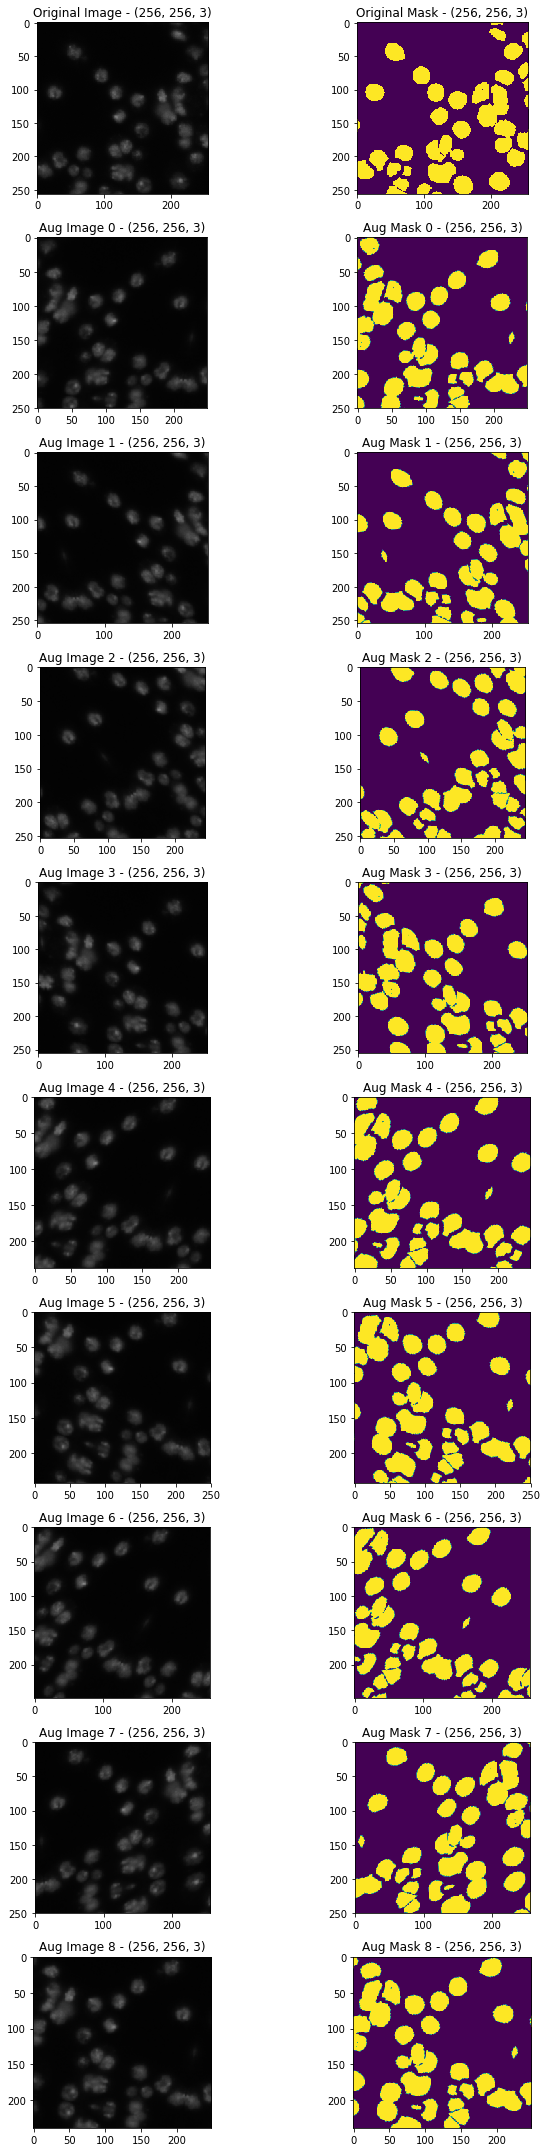

In [33]:
ix = random.randint(0, len(train_ids))
augs = 9

plt.figure(figsize=(10, 30))

plt.subplot(augs+1,2,1)
plt.imshow(X_train_no_resize[ix])
plt.title("Original Image - " + str(np.shape(X_train_no_resize[ix])))

plt.subplot(augs+1,2,2)
plt.imshow(np.squeeze(Y_train_no_resize[ix]))
plt.title("Original Mask - " + str(np.shape(X_train_no_resize[ix])))

for i in range(augs):
    aug_image, aug_mask = data_aug(X_train_no_resize[ix], Y_train_no_resize[ix])
    
    plt.subplot(augs+1, 2, 2*i+3)
    plt.imshow(aug_image)
    plt.title("Aug Image " + str(i) + " - " + str(np.shape(X_train_no_resize[ix])))

    plt.subplot(augs+1, 2, 2*i + 4)
    plt.imshow(np.squeeze(aug_mask))
    plt.title("Aug Mask " + str(i) + " - " + str(np.shape(X_train_no_resize[ix])))

plt.tight_layout()
plt.show()

In [52]:
def resize_image(image):
    pad_width = 256 - np.shape(image)[1] % 256 if np.shape(image)[1] != 256 else 0
    pad_height = 256 - np.shape(image)[0] % 256 if np.shape(image)[0] != 256 else 0
    new_image = np.pad(image, ((0,pad_height), (0,pad_width), (0,0)), mode='reflect')
    return new_image

def break_image(image):
    images = []
    num_col = int(np.shape(image)[0] / 256)
    num_row = int(np.shape(image)[1] / 256)
    for i in range(num_col):
        for j in range(num_row):
            images.append(image[i*256:(i+1)*256,j*256:(j+1)*256,:])
    return images

def make_images(images, shape):
    num_col = shape[0] / 256 + 1 if shape[0] != 256 else 0 
    num_row = shape[1] / 256 + 1 if shape[1] != 256 else 0 
    new_image = np.zeros((num_col*256, num_row*256, shape[2]))
    for i in range(num_col):
        for j in range(num_row):
            new_image[i*256:(i+1)*256,j*256:(j+1)*256,:] = images[i*num_row+j]
    return new_image[:shape[0], :shape[1],:]
    

# (256, 512, 3)
#print(np.shape(Y_train_no_resize[i]))
#big_image = resize_image(Y_train_no_resize[i])
#print(np.shape(big_image))


#plt.figure()
#plt.imshow(np.squeeze(Y_train_no_resize[i]))
#plt.show()

#plt.figure()
#plt.imshow(np.squeeze(big_image))
#plt.show()

#images = break_image(big_image)
#num_col = np.shape(big_image)[0] / 256
#num_row = np.shape(big_image)[1] / 256
#plt.figure()
#for j in range(len(images)):
#    plt.subplot(num_col, num_row, j+1)
#    plt.imshow(np.squeeze(images[j]))
#plt.show()

#new_big_image = make_images(images, np.shape(Y_train_no_resize[i]))
#plt.figure()
#plt.imshow(np.squeeze(new_big_image))
#plt.show()
images = []
for i in range(len(Y_train_no_resize)):
    images.extend(break_image(resize_image(Y_train_no_resize[i])))
print(len(images))

2407


In [53]:
cluster_dict = {}
with open('clusters.txt','r') as f:
    for line in f.readlines():
        temp = line.split(',')
        if temp[1] != 'image_id':
            cluster_dict[temp[1]] = temp[2].strip()

In [61]:
AUGMENT_PATH = 'data/stage1_train_aug/'
augs = 9

images_counter = {'0':0, '1':0, '2':0}

for ix in range(len(train_ids)):
    cluster = cluster_dict[train_ids[ix]]
    path = AUGMENT_PATH + 'cluster_' + cluster
    images = break_image(resize_image(X_train_no_resize[ix]))
    masks = break_image(resize_image(Y_train_no_resize[ix]))
    for j in range(len(images)):
        imsave(path+'/images/image_'+str(images_counter[cluster])+'.png', images[j])
        imsave(path+'/masks/mask_'+str(images_counter[cluster])+'.png', np.squeeze(masks[j]))
        images_counter[cluster] += 1
    for i in range(augs):
        new_image, new_mask = data_aug(X_train_no_resize[ix], Y_train_no_resize[ix])
        images = break_image(resize_image(new_image))
        masks = break_image(resize_image(new_mask))
        for j in range(len(images)):
            imsave(path+'/images/image_'+str(images_counter[cluster])+'.png', images[j])
            imsave(path+'/masks/mask_'+str(images_counter[cluster])+'.png', np.squeeze(masks[j]))
            images_counter[cluster] += 1
print(images_counter)

{'2': 2787, '0': 15861, '1': 1188}
